# HW1 - Stochastic Gradient Descent
author: Kelvin Lin

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def model_variable(shape, name, initializer=tf.random_normal_initializer(stddev=0.1)):
        variable = tf.get_variable(name=name,
                                   dtype=tf.float32,
                                   shape=shape,
                                   initializer=initializer
        )
        tf.add_to_collection('model_variables', variable)
        tf.add_to_collection('l2', tf.reduce_sum(tf.pow(variable,2)))
        return variable
    
class Model():
    def __init__(self, sess, data, nEpochs, learning_rate, M):
        self.sess = sess
        self.data = data
        self.nEpochs = nEpochs
        self.learning_rate = learning_rate
        self.M = M
        self.build_model()
        
    def build_model(self):
        self.x = tf.placeholder(tf.float32, shape=[])
        self.y = tf.placeholder(tf.float32, shape=[])
        
        M = self.M
        w_shape = [M]
        
        self.w = model_variable(w_shape, 'w')
        self.b = model_variable([], 'b', tf.constant_initializer())
        self.mu = model_variable(w_shape, 'mu')
        self.sig = model_variable(w_shape, 'sig', tf.ones_initializer())

        self.phi = tf.exp(
                    tf.negative(
                        tf.pow(
                            tf.divide((self.x - self.mu),self.sig),2)))
        self.yhat =  tf.reduce_sum(self.w*self.phi) + self.b

        self.mse = tf.reduce_mean(tf.pow(self.yhat - self.y, 2))
        
    def train_init(self):
        model_variables = tf.get_collection('model_variables')            
        self.optim = (
            tf.train.GradientDescentOptimizer(learning_rate=0.1)
            .minimize(self.mse, var_list=model_variables)
            )
        self.sess.run(tf.global_variables_initializer())

    def train_iter(self, x, y):
        self.sess.run(self.optim,
                      feed_dict={self.x : x, self.y : y})

    def train(self):
        for _ in range(self.nEpochs):
            for x, y in self.data():
                self.train_iter(x, y)

    def infer(self, x):
        return self.sess.run(self.yhat, feed_dict={self.x : x})

def data():
    num_samp = 50
    sigma = 0.1
    np.random.seed(31415)
    for _ in range(num_samp):
        x = np.random.uniform(-np.pi, np.pi)
        y = np.sin(x) + np.random.normal(0,sigma)
        yield x, y

In [3]:
# model init

sess = tf.Session()
model = Model(sess, data, nEpochs=100, learning_rate=1e-2, M=2)

In [4]:
# train model

model.train_init()
model.train()

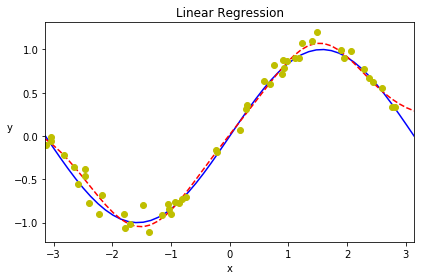

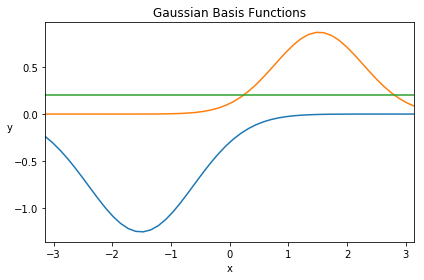

In [5]:
# generate manifold and plot

N= 50
x= np.linspace(-np.pi, np.pi, N)

y = []
yhat = []
phiplt = []
for a in x:
    y.append(np.sin(a))
    yhat.append(model.infer(a))
    phiplt.append(sess.run(model.phi, feed_dict={model.x: a}))
yhat = np.array(yhat)

examples, targets = zip(*list(data()))

plt.plot(x, y, color='b')
plt.plot(x, yhat, '--', color='r')
plt.plot(np.array(examples), np.array(targets), 'o', color='y')
plt.xlim([-np.pi, np.pi])
plt.xlabel('x')
plt.ylabel('y').set_rotation(0)
plt.title('Linear Regression')
plt.tight_layout()
plt.show()

wplt = sess.run(model.w)
bplt = sess.run(model.b)


plt.plot(x, wplt * phiplt)
plt.plot(x, bplt * np.ones(x.shape))
plt.xlim([-np.pi, np.pi])
plt.xlabel('x')
plt.ylabel('y').set_rotation(0)
plt.title('Gaussian Basis Functions')
plt.tight_layout()
plt.show()